In [1]:
############################################################
## Code for fitting the Regression Enhanced Random Forest ##
############################################################

#define the predictor variables
predictor_variables = ['EVI_U', 'EVI_D', 'LOG_AREA', 'WSA_D', 'ELEVATION_D', 'RH', 'TP', 'STD_ELEVATION_U']

test_train_split = 'early_late'
#test_train_split = 'odd_even'

num_predictors = len(predictor_variables)
# Import required packages
import numpy as np
import pandas as pd
import pickle
import os
import earthpy as et

#use grid search to find hyperparameters
from sklearn.model_selection import GridSearchCV                  #for cross validation
#from sklearn.feature_selection import RFE                        #for selecting features for the linear reg
#from sklearn.model_selection import cross_val_score              #for cross validation
#from sklearn.model_selection import KFold                             
from sklearn.preprocessing import StandardScaler                  #for normalising the data
from sklearn.metrics import r2_score                              #metrics for assessing model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures              #for to get squared features and interactions for RR
#for timing how long it takes to fit model
from datetime import datetime
import sys                                                         #for array computing

#define the overpass time 
overpass_time = '13:30'

#define the target variable
#target_variable = 'SUHI_PEAK_GSA'
#target_variable = 'SUHI_PEAK_QUANTILE'
target_variable = 'SUHI_MEAN'
#target_variable = 'SUHI_FP'

num_predictors = len(predictor_variables)
# define the scaler to be used to normalise the data (standard or min max?)
scaler = StandardScaler()

#Load up the data
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'MEAN_SUHI'))
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon_final.xlsx', index_col=None)

#read the table with all variables in as pickle 
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','UHI_Project_Pickle_Files','All_cities'))   
with open('aqua_all_monthly_data_df2.pkl', 'rb') as f:
    all_monthly_data_df = pickle.load(f)
    
all_monthly_data_df = all_monthly_data_df[(all_monthly_data_df['Overpass'] == overpass_time)].reset_index(drop = True)

#URBAN - RURAL differences
all_monthly_data_df['EVI_D'] = all_monthly_data_df['EVI_U'] - all_monthly_data_df['EVI_R']                   # EVI difference

all_monthly_data_df['WSA_D'] = all_monthly_data_df['WSA_U'] - all_monthly_data_df['WSA_R']                   # albedo difference

all_monthly_data_df['ELEVATION_D'] = all_monthly_data_df['ELEVATION_U'] - all_monthly_data_df['ELEVATION_R'] # elevation difference

all_monthly_data_df['LOG_AREA'] = np.log10(all_monthly_data_df.Monthly_Area.values.astype(float))

#clean the data - first remove columns which are not the target or predictor variables, then remove nans
variables = predictor_variables.copy()
variables.append(target_variable)
variables.append('Overpass')
variables.append('month')
variables.append('year')
variables.append('CITY_COUNTRY')
variables.append('City')
all_monthly_data_df2 = all_monthly_data_df[variables]
all_monthly_data_df2 = all_monthly_data_df2.dropna().reset_index(drop = True)

#create training and test datasets
#early years train, later years test
#create the datasets
data_first_yrs = all_monthly_data_df2[((all_monthly_data_df2['year'] <=2011 ) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()
data_last_yrs = all_monthly_data_df2[((all_monthly_data_df2['year'] > 2011)
                                  & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()


all_yrs = [2002, 2003,2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
                 2020]
odd_yrs = [2003, 2005, 2007, 2009, 2011,  2013,  2015,  2017,  2019]

data_odd_yrs = all_monthly_data_df2[((all_monthly_data_df2['year'].isin(odd_yrs)) 
                                    & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()
data_even_yrs = all_monthly_data_df2[(~(all_monthly_data_df2['year'].isin(odd_yrs))
                                  & (all_monthly_data_df2['Overpass'] == overpass_time))].copy()

if test_train_split == 'early_late':
    training_data = data_first_yrs
    test_data = data_last_yrs    
    
if test_train_split == 'odd_even':
    training_data = data_odd_yrs
    test_data = data_even_yrs        
    
print('Train_percent', 100* len(training_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] 
                                                                            == overpass_time]))
print('Test_percent', 100* len(test_data)/len(all_monthly_data_df2[all_monthly_data_df2['Overpass']
                                                                            == overpass_time]))
print('Total Datapoints',len(all_monthly_data_df2[all_monthly_data_df2['Overpass'] == overpass_time]))

#split the data into predictors and target
X_train = training_data[predictor_variables]  #predictors
y_train = training_data[target_variable]      #target

X_test = test_data[predictor_variables]       #predictors
y_test = test_data[target_variable]           #target

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) #fit and transform
X_test_norm = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns) #transform only

y_train_norm = pd.DataFrame(scaler.fit_transform(y_train.values.reshape(-1,1)), columns = [target_variable]) #fit and transform
y_test_norm = pd.DataFrame(scaler.transform(y_test.values.reshape(-1, 1)), columns = [target_variable]) #transform only

#create lists for the model metrics to be stored 
model_name_list = [] 
train_r2_list = []
test_r2_list = []
train_rmse_list = []
test_rmse_list = []
train_mae_list = []
test_mae_list = []

#function to append the model metrics
def add_metrics(model, y_train, y_test, y_train_pred, y_test_pred):
    model_name_list.append(model)
    train_rmse_list.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
    test_rmse_list.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    train_r2_list.append(r2_score(y_train, y_train_pred))
    test_r2_list.append(r2_score(y_test, y_test_pred))
    train_mae_list.append(mean_absolute_error(y_train, y_train_pred))
    test_mae_list.append(mean_absolute_error(y_test, y_test_pred))


####################################
######### FIT THE RERF  ############
####################################

# import required packages
from sklearn.linear_model import Ridge                                #the base estimator
from lineartree import LinearForestRegressor
from sklearn.datasets import make_regression

#create the RERFR model
rerf_reg = LinearForestRegressor(base_estimator=Ridge())

print("Fitting the RERFR...")
startTime = datetime.now()                                            #start timer for RFR fit
folds = 5                                                             #define the number of folds (K)
#specify the hyperparameters to test
#num_features_for_split = total_input_features/3
hyper_params = {'base_estimator__alpha':[0,1e-5,0.01,0.1,1,10, 100,1000]   #RR alpha
                ,'n_estimators':[100, 200]                                 #the number of trees
                ,'max_depth':[10,20,30,40,50,60,70,80,90,100,None]         #the tree depth
                ,'min_samples_leaf':[8,15, 20, 50]                         #min number of samples required at each leaf node
                ,'min_samples_split':[8,15, 20, 50]                        #min number of samples required to split a node
                ,'max_features':[None,num_predictors-1, num_predictors-2]} #the subset of features to consider to split a node

#use cross validation to determine the hyperparameter values
rerf_model_cv = GridSearchCV(estimator = rerf_reg, 
                        param_grid = hyper_params, 
                        cv = folds, 
                        #verbose = 1,                                  #verbose- how detailed output is   
                        return_train_score=True) 
#fit the model
rerf_model_cv.fit(X_train_norm.values, y_train)
print('RERF fit time:', datetime.now() - startTime)                    #print how long it took to fit model

#Generate r square, RMSE and MAE
y_train_pred = rerf_model_cv.predict(X_train_norm)                     #predict the training 
y_test_pred = rerf_model_cv.predict(X_test_norm)                       #predict the test
add_metrics('RERF', y_train, y_test, y_train_pred, y_test_pred)        #generate the stats & save

##save the model
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT', 'CITY_ADD_2022_09','All_cities_modelling'))
filename = 'RERF_{}_{}.sav'.format(target_variable, test_train_split)
pickle.dump(rerf_model_cv, open(filename, 'wb'))

####################### END OF MODEL FITS ##########################

#Put the metrics into a df and save as pickle
d = {'Model': model_name_list, 'Train_r2':train_r2_list,'Test_r2':test_r2_list, 
     'Train_RMSE':train_rmse_list,'Test_RMSE':test_rmse_list, 'Train_MAE': train_mae_list,
     'Test_MAE': test_mae_list}
metrics_df = pd.DataFrame(data = d)
with open('metrics_dataframe_{}.pkl'.format('RERF',test_train_split ), 'wb') as f:
    pickle.dump(metrics_df, f)

Train_percent 58.01660396938643
Test_percent 41.98339603061357
Total Datapoints 15418
Fitting the RERFR...
RERF fit time: 1 day, 13:57:26.707900


C:\Users\UEA_Laptop\.conda\envs\suhienv_linear_tree\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\UEA_Laptop\.conda\envs\suhienv_linear_tree\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LinearForestRegressor was fitted without feature names
  warnings.warn(


In [2]:
rerf_model_cv.best_params_

{'base_estimator__alpha': 1000,
 'max_depth': 20,
 'max_features': 6,
 'min_samples_leaf': 8,
 'min_samples_split': 50,
 'n_estimators': 100}

In [3]:
metrics_df

,Model,Train_r2,Test_r2,Train_RMSE,Test_RMSE,Train_MAE,Test_MAE
0,RERF,0.910807,0.855265,0.707647,0.929452,0.527138,0.700099


In [4]:
import matplotlib.pyplot as plt

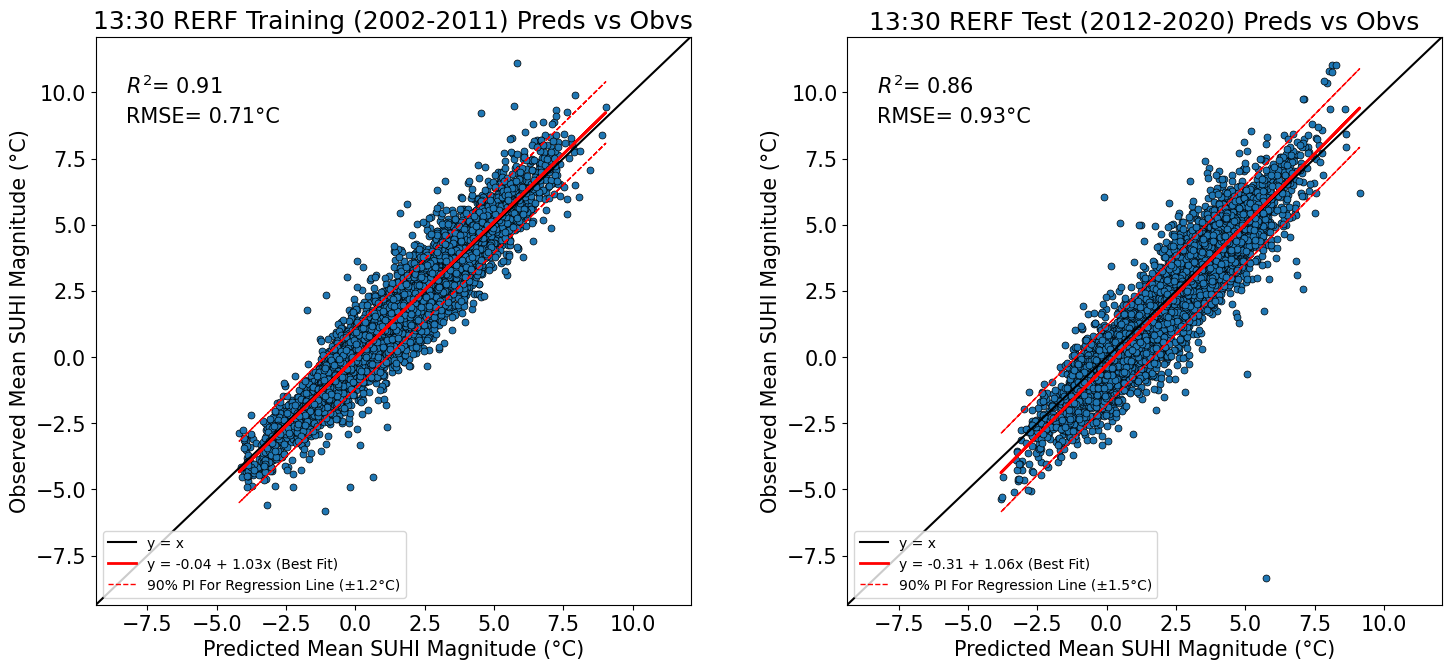

In [13]:
import statsmodels.api as sm  

model_name = 'RERF'

#plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
#plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=20)  # fontsize of the figure title

#set the axes labels
if target_variable == 'SUHI_PEAK_GSA':
    xlab = 'Predicted GSA Peak SUHI Magnitude (\u00b0C)'
    ylab = 'Observed GSA Peak SUHI Magnitude (\u00b0C)'
elif target_variable == 'SUHI_MEAN':
    xlab = 'Predicted Mean SUHI Magnitude (\u00b0C)'
    ylab = 'Observed Mean SUHI Magnitude (\u00b0C)'

# set the plot titles
if test_train_split == 'early_late':
    train_title = '13:30 {} Training (2002-2011) Preds vs Obvs'.format(model_name)
    test_title = '13:30 {} Test (2012-2020) Preds vs Obvs'.format(model_name)
    
if test_train_split == 'odd_even':
    train_title = '13:30 {} Training (Odd Years) Preds vs Obvs'.format(model_name)
    test_title = '13:30 {} Test (Even Years) Preds vs Obvs'.format(model_name)

# PLOTS: predictions vs obvs with line of best fit 

fig, axes = plt.subplots(1,2, figsize = (16, 8))
fig.tight_layout(pad=7.0)
# training data
axes[0].scatter( y_train_pred, y_train, s = 25, edgecolors='k', linewidths=0.5)
axes[0].set(title = train_title, 
         xlabel = xlab, ylabel = ylab)

axesmin = min(min(y_train), min(y_train_pred),min(y_test), min(y_test_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred), max(y_test), max(y_test_pred)) + 1

axes[0].set_xlim([axesmin, axesmax])
axes[0].set_ylim([axesmin, axesmax])
# x = y line
axes[0].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')
# line of best fit
#p, V = np.polyfit(y_train_pred, y_train, 1, cov = True)
#a, b = p[0], p[1]

#get the intercept/ slope of best fit line and prediction interval
sm_model = sm.OLS(y_train, sm.add_constant(y_train_pred)).fit()
b = sm_model.params[0]
a = sm_model.params[1]
sm_pred = sm_model.get_prediction(sm.add_constant(y_train_pred))\
                  .summary_frame(alpha=0.1)

pred_interval_lower = sm_pred.obs_ci_lower.values
pred_interval_upper = sm_pred.obs_ci_upper.values
mean_PI = ((pred_interval_upper - pred_interval_lower)/2).mean()

axes[0].plot(y_train_pred, a*y_train_pred+b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')


axes[0].plot(y_train_pred , pred_interval_lower, color = 'r', linestyle='--', linewidth=1
             ,label = '90% PI For Regression Line ({}{:.1f}\u00b0C)'.format(u'\u00B1',mean_PI))
axes[0].plot(y_train_pred , pred_interval_upper, color = 'r', linestyle='--', linewidth=1)


#text labels
axes[0].text(0.05, 0.9, '$R^2$= {}'.format(round(train_r2, 2)), fontsize=15, transform=axes[0].transAxes)
axes[0].text(0.05, 0.85, 'RMSE= {}\u00b0C'.format(round(train_rmse, 2)), fontsize=15, transform=axes[0].transAxes)

axes[0].legend(loc = 3)
# test data
axes[1].scatter(y_test_pred, y_test, s = 25, edgecolors='k', linewidths=0.5)
axes[1].set(title = test_title, 
         xlabel = xlab, ylabel = ylab)

axesmin = min(min(y_train), min(y_train_pred),min(y_test), min(y_test_pred)) - 1
axesmax = max(max(y_train), max(y_train_pred), max(y_test), max(y_test_pred)) + 1

axes[1].set_xlim([axesmin, axesmax])
axes[1].set_ylim([axesmin, axesmax])
axes[1].plot([axesmin, axesmax],[axesmin, axesmax], color = 'k', label = 'y = x')
#get the intercept/ slope of best fit line and prediction interval
sm_model = sm.OLS(y_test, sm.add_constant(y_test_pred)).fit()
b = sm_model.params[0]
a = sm_model.params[1]
sm_pred = sm_model.get_prediction(sm.add_constant(y_test_pred))\
                  .summary_frame(alpha=0.1)

pred_interval_lower = sm_pred.obs_ci_lower.values
pred_interval_upper = sm_pred.obs_ci_upper.values
mean_PI = ((pred_interval_upper - pred_interval_lower)/2).mean()
axes[1].plot(y_test_pred, a*y_test_pred +b, color='r', linestyle='-', linewidth=2, label = 'y = ' + '{:.2f}'.format(b)+ 
             ' + {:.2f}'.format(a) + 'x (Best Fit)')


axes[1].plot(y_test_pred , pred_interval_lower, color = 'r', linestyle='--', linewidth=1
            ,label = '90% PI For Regression Line ({}{:.1f}\u00b0C)'.format(u'\u00B1',mean_PI))
axes[1].plot(y_test_pred , pred_interval_upper, color = 'r', linestyle='--', linewidth=1)


axes[1].legend(loc = 3)

axes[1].text(0.05, 0.9, '$R^2$= {}'.format(round(test_r2, 2)), fontsize=15, transform=axes[1].transAxes)
axes[1].text(0.05, 0.85, 'RMSE= {}\u00b0C'.format(round(test_rmse, 2)), fontsize=15, transform=axes[1].transAxes)


#save the plot to go into thesis
os.chdir(os.path.join(et.io.HOME, 'Documents', 'Python_Scripts', 'PROJECT','Chapter_5','Final_Models',target_variable,
                     'Preds_Obvs_Scatters')) 
plt.savefig('preds_vs_obvs_scatter_{}_{}_{}_1330.png'.format(model_name, target_variable,test_train_split), 
                bbox_inches="tight", dpi=800)   # dpi increased to give better quality image, but does take longer to save